In [1]:
import path_configs # noqa
import tensorflow as tf
import settings
from datetime import datetime
import os
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
settings.init()

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print("\nTensorflow report:")
print("Devices:", tf.config.list_physical_devices('GPU'))
print("Version:", tf.__version__)

TRAIN_DATA_LEN: 3714569
VAL_DATA_LEN: 1590319

Tensorflow report:
Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Version: 2.1.0


In [2]:
metadata = pd.read_csv(os.path.join('data', 'images', 'image_metadata.csv'))
print(metadata.set_type.value_counts(normalize=True), '\n')
print(metadata.set_type.value_counts())

train    0.798041
val      0.199340
test     0.002619
Name: set_type, dtype: float64 

train    356456
val       89038
test       1170
Name: set_type, dtype: int64


In [3]:
metadata.sample(6)

,path,set_type,gender,age
70029,data/images/train/male/sixties/spec_5_24423.npy,train,male,sixties
226063,data/images/train/male/thirties/spec_11_27291.npy,train,male,thirties
333603,data/images/train/female/fifties/spec_14_14967...,train,female,fifties
445719,data/images/train/male/teens/spec_3_25611.npy,train,male,teens
374099,data/images/val/female/sixties/spec_5_28644.npy,val,female,sixties
268654,data/images/val/female/fourties/spec_8_28306.npy,val,female,fourties


In [22]:
import time


def _generator(SET_TYPE):
    # start = time.time()
    while True:
        metadata = pd.read_csv(os.path.join('data', 'images',
                                'image_metadata.csv'))
        metadata = metadata[metadata.set_type == 'train']
        metadata.age = metadata.age.map({'teens': 15/100, 'twenties': 25/100,
                                        'seventies': 75/100, 'fifties': 55/100,
                                        'fourties': 45/100, 'thirties': 35/100,
                                        'sixties': 65/100, 'eighties': 85/100}
                                        )
        metadata.gender = metadata.gender.map({'male': 0, 'female': 1})
        metadata = metadata.sample(frac=1)
        L = metadata.shape[0]
        for sample in range(L):
            mel_spec = np.load(metadata.iloc[sample, 0])
            X = librosa.feature.mfcc(S=mel_spec, n_mfcc=32)
            X = np.expand_dims(X, axis=-1)
            y_gender = metadata.iloc[sample, 2]
            y_age = metadata.iloc[sample, 3]
            yield X, y_age

input_shape = (32, 128, 1)

In [5]:
from tensorflow.keras.optimizers import Adam
init_lr = 1e-4
epochs = 20
opt = Adam(lr=init_lr, decay=init_lr / epochs)

def simple_model_ConvBlock(inputs):
    base_layer = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                        activation='relu')(inputs)
    base_layer = tf.keras.layers.MaxPool2D()(base_layer)
    base_layer = tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                        activation='relu')(base_layer)
    base_layer = tf.keras.layers.Flatten()(base_layer)
    base_layer = tf.keras.layers.Dropout(0.2)(base_layer)
    return base_layer

def simple_model_ConvBlock_gender(conv_outputs):
    X = tf.keras.layers.Dense(128, activation='relu')(conv_outputs)
    X = tf.keras.layers.Dropout(0.1)(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    X = tf.keras.layers.Dense(32, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(1)(X)
    gender_output = tf.keras.layers.Activation('sigmoid', name='gender_output')(X)
    return gender_output

def simple_model_ConvBlock_age(conv_outputs):
    X = tf.keras.layers.Dense(128, activation='relu')(conv_outputs)
    X = tf.keras.layers.Dropout(0.1)(X)
    X = tf.keras.layers.Dense(64, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    X = tf.keras.layers.Dense(32, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.1)(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dense(1)(X)
    age_output = tf.keras.layers.Activation('linear', name='age_output')(X)
    return age_output

def assemble_full_model():
    inputs = tf.keras.Input(shape=input_shape)
    conv_block = simple_model_ConvBlock(inputs)
    # conv_block2 = simple_model_ConvBlock(inputs)

    age_branch = simple_model_ConvBlock_age(conv_block)
    # gender_branch = simple_model_ConvBlock_gender(conv_block2)

    model = tf.keras.models.Model(inputs=inputs,
                                  outputs=age_branch)
    return model

model = assemble_full_model()

# model.compile(
#     optimizer=opt,
#     loss={'age_output': 'mse',
#           'gender_output': 'binary_crossentropy'},
#     loss_weights={'age_output': 1,
#                   'gender_output': 1},
#     metrics={'age_output': 'mae',
#              'gender_output': ['accuracy', 'mean_absolute_error']})

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae'])

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 126, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 61, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 101504)            0         
_________________________________________________________________
dropout (Dropout)            (None, 101504)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               129926

In [6]:
tf.convert_to_tensor(np.array([1, 1, 1]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 1, 1])>

In [23]:
metadata = pd.read_csv(os.path.join('data', 'images', 'image_metadata.csv'))

train_set_length = metadata[metadata.set_type=='train'].shape[0]
val_set_length = metadata[metadata.set_type=='val'].shape[0]
batch_size = 64
epochs = 20
steps_per_epoch = train_set_length//batch_size
validation_steps = val_set_length//batch_size

dataset_train = tf.data.Dataset.from_generator(_generator,
                                               args=['train'],
                                               output_types=(tf.dtypes.float32, tf.dtypes.float32),
                                               output_shapes=(input_shape, ()))

dataset_val = tf.data.Dataset.from_generator(_generator,
                                             args=['val'],
                                             output_types=(tf.dtypes.float32, tf.dtypes.float32),
                                             output_shapes=(input_shape, ()))

def scaled(tensor, y1, y2):
    return (tensor-tf.math.reduce_min(tensor))/(tf.math.reduce_max(tensor)-tf.
                                                math.reduce_min(tensor)), y1, y2

# def preprocess_dataset(dataset, batch_size):
#     dataset = dataset.cache()
#     dataset = dataset.batch(batch_size)    
#     dataset = dataset.prefetch(buffer_size=2)    
#     return dataset

dataset_train = preprocess_dataset(dataset_train, batch_size)
dataset_val = preprocess_dataset(dataset_val, batch_size)

In [24]:
%%timeit
iter(dataset_train).next()

1.16 s ± 47.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
times = []
import time
for batch_size in [8, 16, 32, 64, 128, 256, 512]:
    dataset_train = tf.data.Dataset.from_generator(_generator,
                                               args=['train'],
                                               output_types=(tf.dtypes.float32, tf.dtypes.float32),
                                               output_shapes=(input_shape, ())).batch(batch_size)
    start = time.time()
    iter(dataset_train).next()
    times.append(time.time() - start)

times

[0.7622451782226562,
 0.8322489261627197,
 0.9025924205780029,
 1.1262962818145752,
 2.111895799636841,
 2.4679765701293945,
 4.7103166580200195]

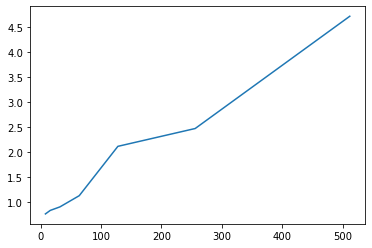

In [30]:
import matplotlib.pyplot as plt
plt.plot([8, 16, 32, 64, 128, 256, 512], times)

In [27]:
%%timeit
i=0
for X, y in _generator('train'):
    i+=1
    if i>64:
        break

1.26 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
now = datetime.now()
date_time = now.strftime("%m_%d_%Y_%H_%M")
NAME = ("model_log_" + date_time)
log_dir = log_dir=os.path.join('logs', str(NAME))

callbacks = [tf.keras.callbacks.TensorBoard(log_dir),
             tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('saved_models', 'checkpoints','{}.h5'.format(NAME)),
                                                monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]
with tf.device('/device:GPU:0'):
    model.fit(
        dataset_train,
        steps_per_epoch = steps_per_epoch,
        epochs = epochs,
        verbose = 1,
        validation_data = dataset_val,
        validation_steps = validation_steps,
        callbacks=callbacks
        )

Train for 11139 steps, validate for 2782 steps
Epoch 1/20
  831/11139 [=>............................] - ETA: 47:37 - loss: 0.2035 - mae: 0.3191WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 